## Downloading the data 

In [1]:
from sklearn.datasets import fetch_mldata
from sklearn.datasets import get_data_home


get_data_home(data_home='datasets/')
data = fetch_mldata('MNIST original')

## Exploring the data 

In [2]:
X, y = data['data'], data['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


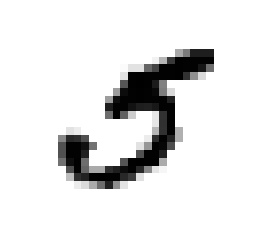

5.0


In [3]:
%matplotlib inline
import matplotlib as mp
import matplotlib.pyplot as plt


digit = X[36000]
image = digit.reshape(28, 28)
plt.imshow(
    image,
    cmap=mp.cm.binary,
    interpolation='nearest'
)
plt.axis('off')
plt.show()
print(y[36000])

## Preparing the test and training set 

In MNIST dataset the daataset is already splitted into test and train sets.
1st 60000 are training data and the rest testing data

In [4]:
import numpy as np


X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
np.random.seed(42)
shuffled_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffled_index], y_train[shuffled_index]

## Training a Binary Classifier for a particular digit 

Training a classifier to classify whether the digit is '5' or 'not 5'

In [5]:
from sklearn.linear_model import SGDClassifier


y_train_5, y_test_5 = (y_train == 5), (y_test == 5)
sgd_model = SGDClassifier(random_state=42)
sgd_model.fit(X_train, y_train_5)
sgd_model.predict(digit)

/Users/maypatha/Environments/ML/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ True])

## Performence Measures

Implementing Cross Validation

In [6]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold


skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_classifier = clone(sgd_model)
    X_train_folds, y_train_folds = X_train[train_index], y_train_5[train_index]
    X_test_folds, y_test_folds = X_train[test_index], y_train_5[test_index]
    clone_classifier.fit(X_train_folds, y_train_folds)
    y_predicted = clone_classifier.predict(X_test_folds)
    correct_predictions = sum(y_predicted == y_test_folds)
    print(correct_predictions / len(y_predicted))

0.9502
0.96565
0.96495


In [7]:
from sklearn.model_selection import cross_val_score


cross_val_score(
    sgd_model,
    X_train,
    y_train_5,
    cv=3,
    scoring='accuracy'
)

array([0.9502 , 0.96565, 0.96495])

Seeing results of a 'Not 5' classifier

In [8]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):

    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


never_5_classifier = Never5Classifier()
cross_val_score(
    never_5_classifier,
    X_train,
    y_train_5,
    cv=3,
    scoring='accuracy'
)

array([0.909  , 0.90715, 0.9128 ])

Using Confusion Matrix

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix


y_train_predict = cross_val_predict(sgd_model, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_predict)

array([[53272,  1307],
       [ 1077,  4344]])

Using Precision and Recall

In [10]:
from sklearn.metrics import precision_score, recall_score


precision_score(y_train_5, y_train_predict)
recall_score(y_train_5, y_train_predict)

0.801328168234643

Using F1 Score

In [11]:
from sklearn.metrics import f1_score


f1_score(y_train_5, y_train_predict)

0.7846820809248555

Precision vs Recall Tradeoff

In [12]:
y_scores = sgd_model.decision_function([digit])
# y_scores
threshold = 200000
digit_prepared = (y_scores > threshold)
# digit_prepared
y_scores = cross_val_predict(sgd_model, X_train, y_train_5, cv=3, method='decision_function')
# y_scores

Getting precision and recall for all possible thresholds

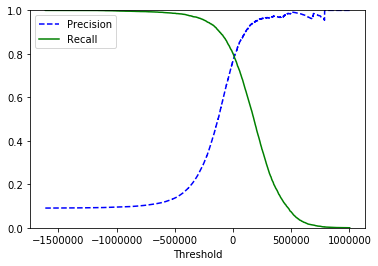

In [13]:
from sklearn.metrics import precision_recall_curve


def plot_precision_recall_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    plt.show()


precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plot_precision_recall_threshold(precisions, recalls, thresholds)

Plotting Precision vs Recall

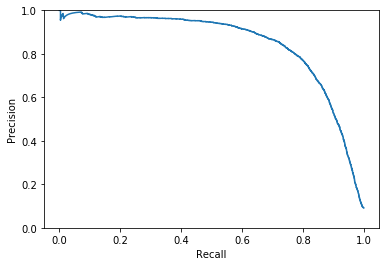

In [14]:
from sklearn.metrics import precision_recall_curve


def plot_precision_recall_threshold(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0, 1])
    plt.show()


precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plot_precision_recall_threshold(precisions, recalls)

In [15]:
y_train_prediction_90 = (y_scores > 70000)
print(precision_score(y_train_5, y_train_prediction_90))
print(recall_score(y_train_5, y_train_prediction_90))

0.8659205116491548
0.6993174691016417


## ROC curve 

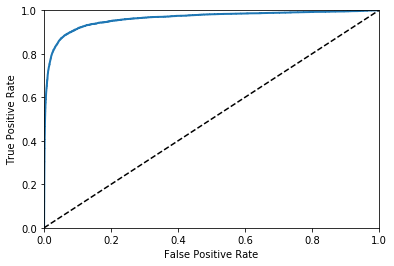

In [16]:
from sklearn.metrics import roc_curve


def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_5, y_scores)
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

Comparing ROC Curve and Area Under ROC Curve of StochiasticGradientDescent classifier and RandomForestClassifier

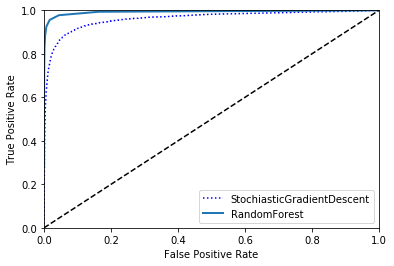

In [17]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(random_state=42)
y_probabilities_forest = cross_val_predict(
    forest_model,
    X_train,
    y_train_5,
    cv=3,
    method='predict_proba'
)
y_scores_forest = y_probabilities_forest[:, -1]
false_positive_rate_forest, true_positive_rate_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(
    false_positive_rate,
    true_positive_rate,
    'b:',
    label='StochiasticGradientDescent'
)
plot_roc_curve(false_positive_rate_forest, true_positive_rate_forest, 'RandomForest')
plt.legend(loc='lower right')
plt.show()

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score


print(roc_auc_score(y_train_5, y_scores))
print(roc_auc_score(y_train_5, y_scores_forest))

0.9624496555967155
0.9931243366003829


## Multiclass Classification 

Using default strategy OvO

In [20]:
sgd_model.fit(X_train, y_train)
print(sgd_model.predict([digit]))
print(sgd_model.decision_function([digit]))

[5.]
[[-311402.62954431 -363517.28355739 -446449.5306454  -183226.61023518
  -414337.15339485  161855.74572176 -452576.39616343 -471957.14962573
  -518542.33997148 -536774.63961222]]


Forcing Scikit-Learn to use any specific strategy

In [21]:
from sklearn.multiclass import OneVsOneClassifier


ovo_model = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_model.fit(X_train, y_train)
print(ovo_model.predict([digit]))
print(len(ovo_model.estimators_))

[5.]
45


In [22]:
print(cross_val_score(
    sgd_model,
    X_train,
    y_train,
    cv=3,
    scoring='accuracy'
))

[0.84063187 0.84899245 0.86652998]


Increasing accuracy by scaling the inputs

In [23]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print(cross_val_score(
    sgd_model,
    X_train_scaled,
    y_train,
    cv=3,
    scoring='accuracy'
))

[0.91011798 0.90874544 0.906636  ]
